## 导入所需库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import lightning as L
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR

## 代码

- 准备数据

In [2]:
# ---------------------------------------------------------
# 1. 数据准备 (包含归一化优化)
# ---------------------------------------------------------
# CIFAR-10 标准均值和标准差, 网络获得
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Pad(4),                   # 填充边界，增加图像信息
    transforms.RandomCrop(32),           # 随机裁剪，取图像的部分

    transforms.RandomHorizontalFlip(),   # 随机水平翻转
    transforms.RandomRotation(17),       # 随机旋转，为了防止过拟合，增加一些角度

    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD) # 启用归一化，利于模型训练
])

test_transform = transforms.Compose([       # 测试集不需要数据增强
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# 数据集加载
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

d:\Anaconda3\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


- 定义model

In [3]:
# ---------------------------------------------------------
# 2. 定义 LightningModule
# ---------------------------------------------------------

class LitResNet(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1. 加载 ResNet18 架构 (weights=None 从零开始训练)
        self.model = models.resnet18(weights=None)
        # 卷积核大小初始层 3*3
        # 卷积层总数17层卷积

        # 2. 适配 CIFAR-10: 修改第一层卷积
        # 原始 ResNet 针对大图，第一层卷积核是 7x7，步长 2
        # 对于 32x32 的小图，改为 3x3 卷积，步长 1，这样可以保留更多空间细节
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity() # 移除 maxpool，因为图片已经很小了

        # 3. 最后的全连接层输出
        # 获取 ResNet 原始输出特征数
        # GAP 把每张图的所有像素取平均值，生成 512 维的向量
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

        # 引入标签平滑
        # 防止模型在猫/狗这种模糊样本上产生“过度自信”的错误
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

        # 3.1 重新定义全连接层结构,实际训练效果不佳，容易过拟合
        # self.model.fc = nn.Sequential(
        #     nn.Linear(num_ftrs, 512),    # 隐藏层
        #     nn.BatchNorm1d(512),         # 归一化：让隐藏层的输出更稳定，加速收敛
        #     nn.ReLU(),                   # 激活函数
        #     nn.Dropout(0.3),             # 随机Dropout：防止过拟合
        #     nn.Linear(512, num_classes)  # 输出层：映射到 10 个类别
        # )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y) # 计算交叉熵损失
        train_acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", train_acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        # 使用 AdamW 效果通常比 Adam 更好，并负责backward
        # Adaptive Moment Estimation 引入了动量概念
        # 开启weight_decay L2正则化，防止过拟合
        # 搭配学习率调度器使用
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=0.001) #weight_decay 原先为0.05

        # 使用 OneCycleLR 自动调节学习率
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.hparams.lr * 10,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.1,   # 前 10% 时间升压
            # div_factor=25,  # 初始学习率为 max_lr 的 1/div_factor
            # final_div_factor=10000 # 结束时学习率为初始的 1/final_div_factor
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

- 训练

In [ ]:
# ---------------------------------------------------------
# 3. 训练器设置与启动
# ---------------------------------------------------------

# 1. 实例化模型
model = LitResNet(num_classes=10, lr=0.0011)

# 2. 核心优化：编译模型
# 这一步会让 ResNet18 的运行速度提升不少
model = torch.compile(model)

# 3. 配置 Trainer
torch.set_float32_matmul_precision('high')
trainer = L.Trainer(
    max_epochs=25,
    accelerator="gpu",
    devices=1,
    precision="bf16-mixed",
    benchmark=True          # 优化固定尺寸输入
)

# 4. 开始
trainer.fit(model, train_loader)

## 继续训练

In [ ]:
torch.set_float32_matmul_precision('high')
model = LitResNet.load_from_checkpoint(
    "model_withRN3.ckpt", # 之前保存的模型文件达到了92.7%的准确率
    num_classes=10,
    lr=0.0001
)

model = torch.compile(model)

# 因为是新的训练任务，将 max_epochs 设为 2
trainer = L.Trainer(
    max_epochs=2,
    accelerator="gpu",
    devices=1,
    precision="bf16-mixed",
    benchmark=True
)

trainer.fit(model, train_dataloaders=train_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet           │ 11.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 69                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=2` reached.


## 模型测试与保存

In [ ]:
# ---------------------------------------------------------
# 4. 测试模型准确率
# ---------------------------------------------------------
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)

Test Accuracy: 93.30%


In [ ]:
#  保存模型
trainer.save_checkpoint("model_withRN5_reach93.3.ckpt")

`weights_only` was not set, defaulting to `False`.


## 混淆矩阵分析

正在进行推理分析...


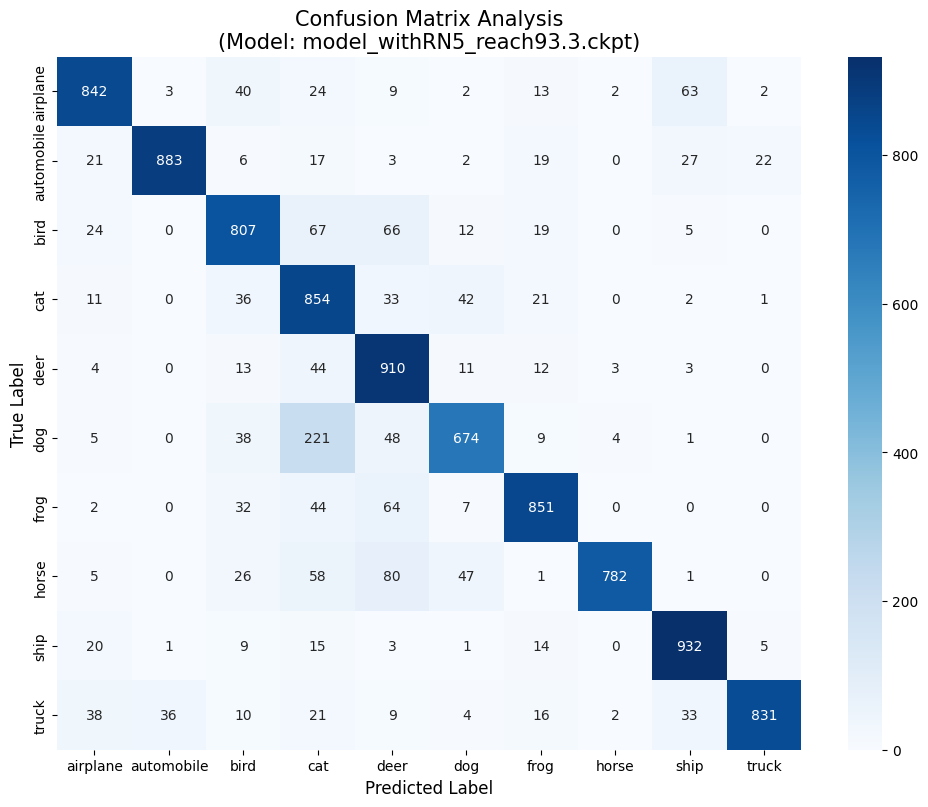

In [ ]:
import torch
import lightning as L
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 定义数据预处理 (必须与训练时一致)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. 加载测试数据集
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=8, pin_memory=True)

# 3. 加载模型
checkpoint_path = "model_withRN5_reach93.3.ckpt"
model = LitResNet.load_from_checkpoint(checkpoint_path)
model.eval()
model.freeze() # 冻结参数，只做推理

# 4. 初始化混淆矩阵工具
num_classes = 10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)

# 5. 运行推理
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
confmat.to(device)

print("正在进行推理分析...")
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        confmat.update(preds, y)

# 6. 计算结果并绘图
cm = confmat.compute().cpu().numpy()

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title(f"Confusion Matrix Analysis\n(Model: {checkpoint_path})", fontsize=15)
plt.show()

可见还是在猫狗会非常容易混淆

## 转化为纯参数

In [4]:
import torch

# 1. 加载完整的 Checkpoint
ckpt_path = "model_withRN5_reach93.3.ckpt"
model = LitResNet.load_from_checkpoint(ckpt_path, num_classes=10)

# 2. 提取纯参数 (state_dict)
state_dict = model.state_dict()

# 3. 保存为纯参数文件
torch.save(state_dict, "model_withRN5_reach93——onlyP.pth")